In [ ]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [1]:
import functions
human = functions.Human()

In [2]:
human.age, human.gender, human.basal_metabolic_rate()

(35, 'male', 1675.8)

In [3]:
# help(functions.Human())

In [4]:
# Convert Celsius to Fahrenheit
help(functions.celsius_to_fahrenheit(13))

Help on float object:

class float(object)
 |  float(x) -> floating point number
 |  
 |  Convert a string or number to a floating point number, if possible.
 |  
 |  Methods defined here:
 |  
 |  __abs__(self, /)
 |      abs(self)
 |  
 |  __add__(self, value, /)
 |      Return self+value.
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __divmod__(self, value, /)
 |      Return divmod(self, value).
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __float__(self, /)
 |      float(self)
 |  
 |  __floordiv__(self, value, /)
 |      Return self//value.
 |  
 |  __format__(...)
 |      float.__format__(format_spec) -> string
 |      
 |      Formats the float according to format_spec.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getformat__(...) from builtins.type
 |      float.__getformat__(typestr) -> string
 |      
 |      You probably don't want to use thi

In [5]:
# Convert Celsius to Kelvin
functions.celsius_to_kelvin(0)

273.15

In [6]:
# Convert Fahrenheit to Celsius
functions.fahrenheit_to_celsius(82.4)

28.000000000000004

In [7]:
# Calculate the Heat Index
functions.heat_index(22, 30)

(21.038888888888884, 0, True)

In [8]:
# Get the Dewpoint Temperature
functions.dewpoint_temperature(20, 101)

C:\Users\tgerrish\Documents\GitHub\climate\functions.py:368: UserWarning: Value input for RH is outside the range suitable for accurate Dewpoint estimation
  warnings.warn("Value input for RH is outside the range suitable for accurate Dewpoint estimation")


20.161070572436692

In [9]:
# Calculate the Humidity Index
functions.humidity_index(20, 9.2)

(20.917678437748936, 0, True)

In [10]:
# Calculate the Discomfort Index
functions.discomfort_index(20, 50)

(18.4875, 6, True)

In [11]:
# Get the wind chill temperature
functions.wind_chill_temperature(0, 2.5)

(-3.0399222228067426, 1, False)

In [12]:
# Get Wet-Bulb Glob Temperature
functions.wet_bulb_globe_temperature_outdoors(15, 15, 10253, 1)

(12.83225332, 0, True)

In [13]:
# Get effective temperature
functions.effective_temperature(14, 58, 0.1, 0, 0.5)

(13.328, 2, False)

In [14]:
# Estimate wind speed at another height
functions.wind_speed_at_height(1, 10, 100, log=True)

1.2128125949042536

In [15]:
# Estimate ground temperature
functions.ground_temperature(
    depth=0.1,
    annual_average_temperature=13.2,
    annual_temperature_range=14,
    days_since_coldest_day=10,
    soil_diffusivity=0.02
)

6.6816422245088996

In [10]:
# Load weather from MongoDB
home_ip = "192.168.1.80"
work_ip = "172.16.38.51"
weather = functions.load_weather(work_ip, 27017)
weather.keys()

dict_keys(['year', 'zenithLuminance', 'snowDepth', 'dryBulbTemperature', 'horizontalInfraredRadiationIntensity', 'extraterrestrialHorizontalRadiation', 'visibility', 'diffuseHorizontalIlluminance', 'aerosolOpticalDepth', 'ceilingHeight', 'hour', 'presentWeatherObservation', 'liquidPrecipitationQuantity', 'directNormalIlluminance', 'elevation', 'wmoStation', 'dataSource', 'relativeHumidity', 'extraterrestrialDirectNormalRadiation', 'precipitableWater', 'globalHorizontalIlluminance', 'windSpeed', 'diffuseHorizontalRadiation', 'latitude', 'region', 'directNormalRadiation', 'daysSinceLastSnowfall', 'totalSkyCover', 'groundTemperature', 'albedo', 'country', 'liquidPrecipitationDepth', 'comments', 'windDirection', 'dataSourceAndUncertaintyFlags', 'globalHorizontalRadiation', 'longitude', 'dewPointTemperature', 'atmosphericStationPressure', 'timeZone', 'month', 'opaqueSkyCover', '_id', 'minute', 'city', 'presentWeatherCodes', 'day'])

In [12]:
_latitude = weather["latitude"]
_longitude = weather["longitude"]
_time_zone = weather["timeZone"]

# Determine sun position from location and date/time
functions.sun_position(
    latitude=_latitude, 
    longitude=_longitude, 
    time_zone=_time_zone, 
    year=2000, month=3, day=1, hour=1, minute=0, second=0
)

(-72.0382279548014, 21.53367049145413)

In [21]:
# Approximating Fangers standing/sitting exposure level
functions.fanger_solar_exposure(altitude=45, azimuth=90)

0.3030724317764811

<IPython.core.display.Javascript object>


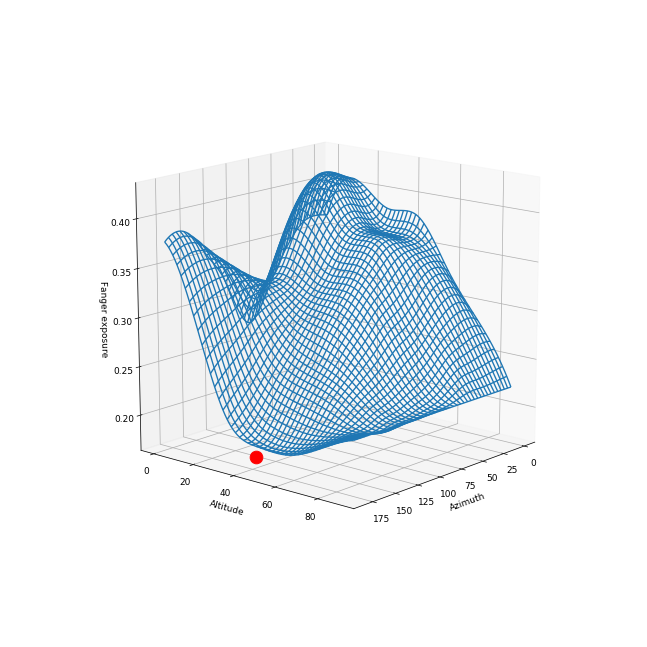

[array([  0.,   0.,   0.,   0.,   0., 180., 180., 180., 180., 180.]),
 array([ 0.,  0.,  0.,  0.,  0., 90., 90., 90., 90., 90.]),
 array([ 0.42999558,  0.49777802,  0.28585413,  0.26363318,  0.10059901,
         0.59049987,  0.63936053,  0.41177803,  0.16397939,  0.11456303,
        -0.07290688, -0.08773606,  0.0371988 ,  0.0677106 ,  0.09444999,
         0.55733517,  0.6212236 ,  0.33849902,  0.25505267,  0.10114417,
         0.44329566,  0.49809125,  0.29471169,  0.19682482,  0.10008131]),
 4,
 4]

In [123]:
sitting = np.loadtxt(r"C:\Users\tgerrish\Documents\GitHub\climate\temp\standing.dat", delimiter=',', dtype=float)
standing = np.loadtxt(r"C:\Users\tgerrish\Documents\GitHub\climate\temp\sitting.dat", delimiter=',', dtype=float)

# Plot the values
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import bisplrep, bisplev

alts, azs = np.arange(0, 91, 1), np.arange(0, 181, 1)
alts, azs = np.meshgrid(alts, azs)

tck_sitting = bisplrep(azs.flatten(), alts.flatten(), sitting.flatten(), kx=4, ky=4)
tck_standing = bisplrep(azs.flatten(), alts.flatten(), standing.flatten(), kx=4, ky=4)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
#ax.plot_wireframe(azs, alts, sitting, cmap="viridis", zorder=2)
ax.plot_wireframe(azs, alts, standing, cmap="viridis", zorder=2)
ax.set_xlabel("Azimuth")
ax.set_ylabel("Altitude")
ax.set_zlabel("Fanger exposure")

az = 182
alt = 45.1
ax.scatter(az, alt, bisplev(az, alt, tck_standing), color="r", s=200, zorder=5)
#ax.scatter(az, alt, bisplev(az, alt, tck_sitting), color="r", s=200, zorder=5)

tck_sitting

In [119]:
tck_sitting_ = [[0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 180.0, 180.0, 180.0, 180.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 90.0, 90.0, 90.0, 90.0],
 [0.42999558258469306,
  0.49777802226651985,
  0.2858541264803382,
  0.2636331839991635,
  0.10059901058304405,
  0.5904998653021177,
  0.6393605287969937,
  0.41177803047742195,
  0.16397939147762605,
  0.1145630272512949,
  -0.07290688451711066,
  -0.0877360565501316,
  0.03719879969518147,
  0.06771059788029093,
  0.09444998526069391,
  0.5573351684449549,
  0.6212235986152396,
  0.3384990152297299,
  0.25505266892999545,
  0.1011441730110879,
  0.4432956571996788,
  0.49809124858382825,
  0.29471168936411446,
  0.19682482035937438,
  0.10008130856803796],
 4,
 4]

bisplev(10, 10, tck_sitting_)



0.4617940441231379

In [120]:
[tck_standing[0].tolist(), tck_standing[1].tolist(),tck_standing[2].tolist(), tck_standing[3], tck_standing[4]]


[[0.0, 0.0, 0.0, 0.0, 0.0, 180.0, 180.0, 180.0, 180.0, 180.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 90.0, 90.0, 90.0, 90.0, 90.0],
 [0.365433469329803,
  0.41471995039390336,
  0.3539202584010255,
  0.35205668670475776,
  0.21505967838173534,
  0.5304745700779437,
  0.6180584137541132,
  0.11434859278048302,
  0.4862162611010728,
  0.20252438358996272,
  -0.015147290187610778,
  0.22189948439503024,
  0.6990946114268216,
  -0.000718703369787728,
  0.22472889635480628,
  0.5176922764465676,
  0.35055123160310636,
  -0.0032935618498728487,
  0.3404006983313149,
  0.19936403473400507,
  0.37870178660536147,
  0.24613731159172733,
  0.06300314787643235,
  0.23364607863218287,
  0.2171651821703637],
 4,
 4]

In [ ]:
functions.load_weather("192.168.1.80", 27017)

import pandas as pd

var = "dryBulbTemperature"
idx = pd.DatetimeIndex(start="1989-01-01 00:00", end="1990-01-01 00:00", freq="60T", closed="left")
df = pd.DataFrame(index=idx, columns=[var], data=functions.load_weather("192.168.1.80", 27017)[var]["values"])

In [26]:
import numpy as np

# Load spline data
spline_sit = np.loadtxt("sit_spline_az_alt_temp.dat", delimiter=',', dtype=float)

# Altitudes
alts = np.arange(0, 91)

# Simplify
exponents = []
for azs in spline_sit:
    pfit = np.polyfit(alts, azs, deg=10)
    p = np.poly1d(pfit)
    exponents.append(np.array(p))

spline_sit = [i.tolist() for i in exponents] # Convert to lists
p = np.poly1d(spline_sit[0]) # Get poly1d for later prediction
p(alts) # Predict for altitudes

############################################################

# Load spline data
spline_stand = np.loadtxt("stand_spline_az_alt_temp.dat", delimiter=',', dtype=float)

# Altitudes
alts = np.arange(0, 91)

# Simplify
exponents = []
for azs in spline_stand:
    pfit = np.polyfit(alts, azs, deg=10)
    p = np.poly1d(pfit)
    exponents.append(np.array(p))

spline_sit = [i.tolist() for i in exponents] # Convert to lists
p = np.poly1d(spline_stand[0]) # Get poly1d for later prediction
p(alts) # Predict for altitudes

array([1.07010000e-001, 2.95347600e+001, 1.13452074e+027, 5.99028223e+042,
       9.34415971e+053, 4.61622593e+062, 5.92643275e+069, 6.10545288e+075,
       9.90833584e+080, 3.91615580e+085, 5.07711400e+089, 2.67039786e+093,
       6.66695793e+096, 8.90181601e+099, 6.97448814e+102, 3.45121561e+105,
       1.14449789e+108, 2.67001029e+110, 4.56167290e+112, 5.90302962e+114,
       5.95307046e+116, 4.79387333e+118, 3.14775922e+120, 1.71618345e+122,
       7.89305708e+123, 3.10510771e+125, 1.05774031e+127, 3.15406813e+128,
       8.31297810e+129, 1.95342688e+131, 4.12450226e+132, 7.88000267e+133,
       1.37093875e+135, 2.18448273e+136, 3.20476377e+137, 4.34950833e+138,
       5.48510815e+139, 6.45325394e+140, 7.10933045e+141, 7.35897975e+142,
       7.17985147e+143, 6.62202435e+144, 5.78922422e+145, 4.80947879e+146,
       3.80576564e+147, 2.87476364e+148, 2.07713826e+149, 1.43834041e+150,
       9.56243340e+150, 6.11385305e+151, 3.76518713e+152, 2.23680230e+153,
       1.28364528e+154, 7